# Coopetition of Danish banks

This notebook contains econometric models exploring usage of shared IT providers among Danish banks.

## Step 1. Load KPI spreadsheet from Finanstilsynet

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# PI_D is a hidden sheet that contains the data for pivot tables PI_A & PI_B
kpis = pd.read_excel(io="data/KPI_Penge_fonds_Real_202412.xlsx", sheet_name="PI_D")
kpis.rename(columns={"vaerdi": "value",
                   "År (Year)": "year",
                   "Vælg nøgletal (Choose KPI)": "kpi",
                   "Virksomhedsnavn (Company Name)": "bank"
                   }, inplace=True)
kpis.drop(columns=["Vælg niveau (Choose Company Level)",
                 "Vælg virksomhedsgruppering (Choose Company Grouping)",
                 "ITYPE"], inplace=True)
kpi_map = {
    "Solvensprocent (Solvency ratio)": "solvency_ratio",
    "Kernekapitalprocent (Tier 1 capital ratio)": "tier1_cap",
    "Egenkapitalforrentning før skat (Return on equity before tax)": "roe_pre_tax",
    "Egenkapitalforrentning efter skat (Return on equity after tax)": "roe_post_tax",
    "Indtjening pr. omkostningskrone (Income/cost ratio)": "income_to_cost",
    "Renterisiko (Interest rate risk)": "interest_rate_risk",
    "Valutaposition (Foreign exchange position)": "fx_position",
    "Valutarisiko (Foreign exchange risk)": "fx_risk",
    "Udlån plus nedskrivninger herpå i forhold til indlån (Loans and impairment losses over deposits)": "loans_over_deposits",
    "Overdækning i forhold til lovkrav om likviditet (Excess coverage as a percentage of the liquidity requirement)": "liq_coverage",
    "Summen af store eksponeringer (Sum of large exposures)": "large_exposures",
    "Årets nedskrivningsprocent (Annual impairment ratio)": "impairment_ratio",
    "Årets udlånsvækst (Growth in loans)": "loan_growth",
    "Udlån i forhold til egenkapital (Gearing)": "gearing",
    "Årets resultat pr. aktie (stykstørrelse 100 kr.) (Annual earnings per share (nominal value DKK 100) before tax)": "eps_pre_tax",
    "Årets resultat pr. aktie (stykstørrelse 100 kr.) (Annual earnings per share (nominal value DKK 100) after tax)": "eps_post_tax",
    "Indre værdi pr. aktie (stykstørrelse 100 kr.)(Book value over net asset value)": "book_value_per_share",
    "Børskurs/resultat pr. aktie (stykstørrelse 100 kr.) (Price over net asset value (nominal value DKK 100))": "price_over_nav",
    "Børskurs/indre værdi pr. aktie (stykstørrelse 100 kr.) (Price over book value (nominal value DKK100))": "price_over_book"
}
kpis["kpi"] = kpis["kpi"].map(kpi_map)


## Step 2. Add datacentral information

In [2]:
platforms = pd.read_excel("data/BankByDC.xlsx")
kpis_platforms = kpis.merge(platforms, on="bank", how="left")
# some banks are missing datacentral information - those are not interesting for further analysis
kpis_platforms = kpis_platforms.dropna(subset=["dc"])

## Step 3. From long to wide format
REGNR is one of ids for the banks.

In [3]:
df_wide = kpis_platforms.pivot_table(index=["bank", "year", "dc", "REGNR"], columns="kpi", values="value").reset_index()

## Step 4. Add balance sheet data
PI_regnskaber_2000_2024.xlsx is another spreadsheet from Finanstilsynet that contains balance sheets for the banks. Due to the change in reporting forms across the years, getting the data requires more effort here. We will be using the following metrics:
* Total assets (*Aktiver i alt*), coded as FB0214, AS0222 and Bal_BO_ATot
* Income from fees and commissions (*Gebyrer og provisionsindtægter*), coded as FB0105, AS0105 and Res_GPi_RY
* Income from interest and fees (=total income) (*Netto rente- og gebyrindtægter*), coded as FB0107, AS0107 and Res_RGTot_RY
* Deposits: coded as *Indlån* FB0216 and summed from *Indlån og anden gæld* (AS0224, Bal_BO_PGiag) and *Indlån i puljeordninger* (AS0225, Bal_BO_Pgip)
* Loans: coded as *Udlån* FB0204 and summed from *Udlån og andre tilgodehavender til dagsværdi* (AS0204, Bal_BO_Autd) and *Udlån og andre tilgodehavender til amortiseret kostpris* (AS0205, Bal_BO_Auta)

Total assets are later logarithmized.

Deposits and loans are later expressed as ratio of total assets (as in Dreyer (2018)).

To verify if the bank is more traditional (more income from interest) or digital (income from services), we calculate a third variable which is the percentage of non-interest income.

In [4]:
# Data_FB is a sheet that contains data for 2000-2004 period
balance_00_04 = pd.read_excel(io="data/PI_regnskaber_2000_2024.xlsx", sheet_name="Data_FB")
balance_00_04["year"] = balance_00_04["REGNPER"] // 100
balance_00_04.rename(columns={"FB0214": "total_assets",
                              "FB0105": "fee_commission_income",
                              "FB0107": "total_income",
                              "FB0216": "deposits",
                              "FB0204": "loans",
                              "FB0110": "admin_expenses"},
                     inplace=True)

# Data_AS is a sheet that contains data for 2005-2015 period
balance_05_15 = pd.read_excel(io="data/PI_regnskaber_2000_2024.xlsx", sheet_name="Data_AS")
balance_05_15["year"] = balance_05_15["REGNPER"] // 100
balance_05_15.rename(columns={"AS0222": "total_assets",
                              "AS0105": "fee_commission_income",
                              "AS0107": "total_income",
                              "AS0224": "deposits_other",
                              "AS0225": "pooled_deposits",
                              "AS0204": "loans_fv",
                              "AS0205": "loans_ac",
                              "AS0110": "admin_expenses"},
                     inplace=True)
balance_05_15["deposits"] = balance_05_15["deposits_other"].add(balance_05_15["pooled_deposits"], fill_value=0)
balance_05_15["loans"] = balance_05_15["loans_fv"].add(balance_05_15["loans_ac"], fill_value=0)

# Data_KRGS is a sheet that contains data for 2016-2024 period
balance_16_24 = pd.read_excel(io="data/PI_regnskaber_2000_2024.xlsx", sheet_name="Data_KRGS")
balance_16_24["year"] = balance_16_24["ref_date"] // 100
balance_16_24.rename(columns={"regnr": "REGNR",
                              "Bal_BO_ATot": "total_assets",
                              "Res_GPi_RY": "fee_commission_income",
                              "Res_RGTot_RY": "total_income",
                              "Bal_BO_PGiag": "deposits_other",
                              "Bal_BO_PGip": "pooled_deposits",
                              "Bal_BO_Autd": "loans_fv",
                              "Bal_BO_Auta": "loans_ac",
                              "Res_UPa_RY": "admin_expenses"},
                     inplace=True)
balance_16_24["deposits"] = balance_16_24["deposits_other"].add(balance_16_24["pooled_deposits"], fill_value=0)
balance_16_24["loans"] = balance_16_24["loans_fv"].add(balance_16_24["loans_ac"], fill_value=0)

balance_all = pd.concat(
    [balance_00_04, balance_05_15, balance_16_24],
    ignore_index=True
)

df_wide_balance = df_wide.merge(
    balance_all[["REGNR", "total_assets", "year", "fee_commission_income", "total_income", "deposits", "loans", "admin_expenses"]],
    on=["REGNR", "year"],
    how="left"
)

df_wide_balance["log_total_assets"] = np.log(df_wide_balance["total_assets"])
df_wide_balance["non_interest_income"] = df_wide_balance["fee_commission_income"] / df_wide_balance["total_income"]
df_wide_balance["deposits_over_assets"] = df_wide_balance["deposits"] / df_wide_balance["total_assets"]
df_wide_balance["loans_over_assets"] = df_wide_balance["loans"] / df_wide_balance["total_assets"]
df_wide_balance["admin_exp_over_assets"] = df_wide_balance["admin_expenses"] / df_wide_balance["total_assets"]


## Step 6. Dummies for DCs
Banks can be on one of three datacentrals: BEC, Netcompany Banking Services (NBS) or Bankdata. They can also be a datacentral for themselves (Danske Bank and Nordea), but we ignore those as outliers (they are by order of magnitude bigger than the rest).

In [5]:
df_dummies = df_wide_balance.loc[df_wide_balance["dc"] != "OWN"].copy()

df_dummies["dc"] = pd.Categorical(
    df_dummies["dc"],
    categories=["BEC", "NBS", "Bankdata"],
    ordered=True
)

# BEC is the baseline
df_dummies = pd.get_dummies(df_dummies, columns=["dc"], drop_first=True, dtype=int)


## Step 7. Basic data analysis

The panel is unbalanced, mostly because of banks merging over the years.

Based on Dreyer (2018) and our own experience, we pick the following variables from our dataset:

* income_to_cost (dependent variable)
* dc_NBS (dummy for datacentral)
* dc_Bankdata (dummy for datacentral)
* log_total_assets (as in Dreyer (2018))
* tier1_cap (as in Dreyer (2018))
* deposits_over_assets (as in Dreyer (2018))
* loans_over_assets (as in Dreyer (2018))
* non_interest_income (as in Dreyer (2018))
* gearing (as in Dreyer (2018), where it is called leverage ratio)

Let's check the quality of those.


In [6]:
df_short = df_dummies[["income_to_cost", "dc_NBS", "dc_Bankdata", "log_total_assets", "tier1_cap", "deposits_over_assets", "loans_over_assets", "non_interest_income", "gearing", "year", "bank", "fee_commission_income", "admin_exp_over_assets"]].copy()
for col in df_short:
    pct_missing = np.mean(df_short[col].isnull())
    print(col, '\t', pct_missing * 100, '%')

income_to_cost 	 0.0 %
dc_NBS 	 0.0 %
dc_Bankdata 	 0.0 %
log_total_assets 	 0.0 %
tier1_cap 	 0.0 %
deposits_over_assets 	 0.0 %
loans_over_assets 	 0.0 %
non_interest_income 	 0.0 %
gearing 	 0.22189349112426035 %
year 	 0.0 %
bank 	 0.0 %
fee_commission_income 	 0.0 %
admin_exp_over_assets 	 0.0 %


In [7]:
# basic cleaning - drop NaN rows
df_clean = df_short.dropna()

# TODO: histograms, outliers removal...

In [8]:

# Lag on data

lag_vars = [
   "log_total_assets", "tier1_cap",
    "deposits_over_assets", "loans_over_assets",
    "non_interest_income", "gearing", "fee_commission_income",
    "income_to_cost", "admin_exp_over_assets"
]

df_clean = (
    df_clean
    .set_index(["bank", "year"])
    .sort_index()
    .copy()
)

for v in lag_vars:
    df_clean[v + "_lag"] = df_clean.groupby(level=0)[v].shift(1)

df_clean = df_clean.dropna();

## Step 8. Simple model
income-to-cost on various DCs in 2024

In [9]:
# let's focus only on 2024
df = df_clean.xs(2024, level="year").copy()

y = df["income_to_cost"]
X = df[["dc_NBS", "dc_Bankdata", "log_total_assets_lag", "tier1_cap_lag", "deposits_over_assets_lag", "loans_over_assets_lag", "non_interest_income_lag", "gearing_lag"]]
X = sm.add_constant(X)

# Used robust standard errors (HC3) to account for heteroskedasticity
model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         income_to_cost   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     1.919
Date:                Thu, 22 Jan 2026   Prob (F-statistic):             0.0914
Time:                        17:57:30   Log-Likelihood:                -15.596
No. Observations:                  41   AIC:                             49.19
Df Residuals:                      32   BIC:                             64.61
Df Model:                           8                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

We're surprised by relatively high R<sup>2</sup> given the low number of samples (44). All variables are statistically nonsignificant.

Residuals far from normal.

We need to make a panel analysis.

## Step 9. PooledOLS
In PooledOLS we assume that each bank in each year is a new observation.

                          PooledOLS Estimation Summary                          
Dep. Variable:         income_to_cost   R-squared:                        0.1229
Estimator:                  PooledOLS   R-squared (Between):              0.3355
No. Observations:                1273   R-squared (Within):               0.0439
Date:                Thu, Jan 22 2026   R-squared (Overall):              0.1229
Time:                        18:07:08   Log-likelihood                   -1000.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      22.143
Entities:                          72   P-value                           0.0000
Avg Obs:                       17.681   Distribution:                  F(8,1264)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust):             6.7908
                            

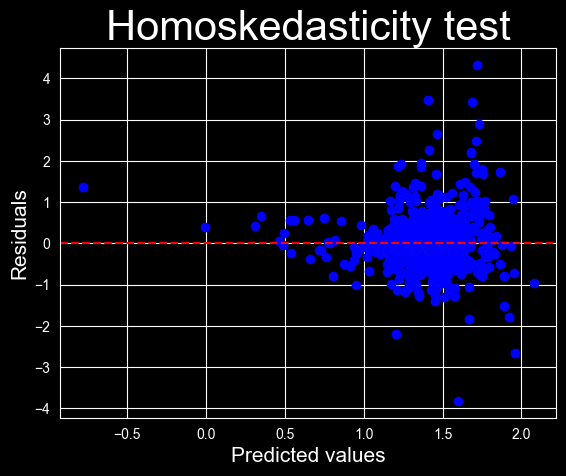

In [21]:
from linearmodels.panel import PooledOLS

df = df_clean.copy()

y = df["income_to_cost"]
X = df[["dc_NBS", "dc_Bankdata", "log_total_assets", "tier1_cap", "deposits_over_assets", "loans_over_assets", "non_interest_income", "gearing"]]
X = sm.add_constant(X)

pooled_mod = PooledOLS(y, X)
pooled_res = pooled_mod.fit(cov_type="clustered", cluster_entity=True)

print(pooled_res.summary)
fittedvals_pooled_OLS = pooled_res.predict().fitted_values
residuals_pooled_OLS = pooled_res.resids

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity test', fontsize = 30)
plt.show()

The model is statistically significant. R<sup>2</sup> rather low, but it is expected in panel. R<sup>2</sup> between = 0.3599: pretty well explains the differences between the banks, and pretty bad changes in time for the bank (R<sup>2</sup> within =0.0418).

The variables are mostly significant and make sense!

But, in general, the finances of the bank explain cost/income better than IT supplier.

## Random effects.

We cannot use Fixed Effects, because the selection of DC is rather constant (changes happen rarely and are mostly effects of bank mergers).



In [22]:
from linearmodels.panel import RandomEffects


re_mod = RandomEffects(y, X)
re_res = re_mod.fit(cov_type="clustered", cluster_entity=True)

print(re_res.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:         income_to_cost   R-squared:                        0.0657
Estimator:              RandomEffects   R-squared (Between):              0.3380
No. Observations:                1273   R-squared (Within):               0.0466
Date:                Thu, Jan 22 2026   R-squared (Overall):              0.1190
Time:                        18:13:39   Log-likelihood                   -884.05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.107
Entities:                          72   P-value                           0.0000
Avg Obs:                       17.681   Distribution:                  F(8,1264)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust):             6.5001
                            

In [15]:
# Hausmann test
from linearmodels.panel import compare
compare({'PooledOLS': pooled_res, 'RE': re_res})

,PooledOLS,RE
Dep. Variable,income_to_cost,income_to_cost
Estimator,PooledOLS,RandomEffects
No. Observations,1273,1273
Cov. Est.,Clustered,Clustered
R-squared,0.1229,0.0657
R-Squared (Within),0.0439,0.0466
R-Squared (Between),0.3355,0.3380
R-Squared (Overall),0.1229,0.1190
F-statistic,22.143,11.107
P-value (F-stat),0.0000,0.0000


In [ ]:
# Mundlak
df_panel_mundlak = df_clean.copy().set_index(["bank", "year"])

time_varying = [
    "log_total_assets",
    "tier1_cap",
    "deposits_over_assets",
    "loans_over_assets",
    "non_interest_income",
    "gearing",
]

for col in time_varying:
    df_panel_mundlak[f"{col}_mean"] = df_panel_mundlak.groupby("bank")[col].transform("mean")
y = df_panel_mundlak["income_to_cost"]

X_cre = df_panel_mundlak[
    [
        "dc_NBS",
        "dc_Bankdata",
        "log_total_assets",
        "tier1_cap",
        "deposits_over_assets",
        "loans_over_assets",
        "non_interest_income",
        "gearing",
        "log_total_assets_mean",
        "tier1_cap_mean",
        "deposits_over_assets_mean",
        "loans_over_assets_mean",
        "non_interest_income_mean",
        "gearing_mean",
    ]
]

cre_mod = RandomEffects(y, X_cre)
cre_res = cre_mod.fit(cov_type="clustered", cluster_entity=True)

print(cre_res.summary)

In [23]:
## Pooled playground

from linearmodels.panel import PanelOLS
import numpy as np

dfp = df_clean.copy()
dfp["post_2019"] = (dfp.index.get_level_values("year") >= 2019).astype(int)
dfp['dc_Bankdata_post2019'] = dfp['dc_Bankdata'] * dfp['post_2019']
dfp['dc_NBS_post2019'] = dfp['dc_NBS'] * dfp['post_2019']
# dfp['fee_income_growth'] = (
#     np.log1p(dfp['fee_commission_income'])
#     .groupby(level='bank')
#     .diff()
# )
dfp['cti_mean_t'] = (
    dfp
    .groupby(level='year')['income_to_cost']
    .transform('mean')
)
dfp['cti_dev'] = abs(dfp['income_to_cost'] - dfp['cti_mean_t'])
dfp = dfp.replace([np.inf, -np.inf], np.nan).dropna()
yp = dfp["cti_dev"]
Xp = dfp[["dc_NBS", "dc_Bankdata", "log_total_assets_lag", "tier1_cap_lag", "deposits_over_assets_lag", "loans_over_assets_lag", "non_interest_income_lag", "post_2019", "dc_NBS_post2019", "dc_Bankdata_post2019"]]
Xp = sm.add_constant(Xp)

from linearmodels.panel import PanelOLS

fe_mod = PanelOLS(
    yp,
    Xp,
    entity_effects=True,
    time_effects=True,
    drop_absorbed=True
)

fe_res = fe_mod.fit(cov_type="clustered", cluster_entity=True)

print(fe_res.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                cti_dev   R-squared:                        0.0628
Estimator:                   PanelOLS   R-squared (Between):             -0.5203
No. Observations:                1273   R-squared (Within):              -0.0069
Date:                Thu, Jan 22 2026   R-squared (Overall):             -0.2772
Time:                        18:16:01   Log-likelihood                   -201.35
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.203
Entities:                          72   P-value                           0.0000
Avg Obs:                       17.681   Distribution:                  F(7,1171)
Min Obs:                       1.0000                                           
Max Obs:                       24.000   F-statistic (robust):             18.895
                            

/var/folders/7b/yfxzgtr11sg43l79k4r2dwgc0000gn/T/ipykernel_40856/2689579690.py:36: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

dc_NBS, dc_Bankdata, post_2019

  fe_res = fe_mod.fit(cov_type="clustered", cluster_entity=True)


In [24]:
# DCs should offer different level of automatization, thus influencing the expenses on staff

dfp = df_clean.copy()
y = dfp["admin_exp_over_assets"]
X = dfp[["dc_NBS", "dc_Bankdata", "log_total_assets_lag", "tier1_cap_lag", "deposits_over_assets_lag", "loans_over_assets_lag"]]

X = sm.add_constant(X)
pooled_mod = PooledOLS(y, X)
pooled_res = pooled_mod.fit(cov_type="clustered", cluster_entity=True)

print(pooled_res.summary)


                            PooledOLS Estimation Summary                           
Dep. Variable:     admin_exp_over_assets   R-squared:                        0.3172
Estimator:                     PooledOLS   R-squared (Between):              0.4239
No. Observations:                   1273   R-squared (Within):               0.1617
Date:                   Thu, Jan 22 2026   R-squared (Overall):              0.3172
Time:                           18:16:55   Log-likelihood                    4169.0
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      98.016
Entities:                             72   P-value                           0.0000
Avg Obs:                          17.681   Distribution:                  F(6,1266)
Min Obs:                          1.0000                                           
Max Obs:                          24.000   F-statistic (robust):            